## **<span style="color:lime">Third section</span>: *clustering example***
| *Cells* | *Content* |
|---|---|
| 3.1 *Setup* | Imports and helpers |
| 3.2 *Encode & cluster* | HashComb tokens as cluster IDs |
| 3.3 *Cluster stats* | Token-level summaries |
| 3.4 *K-means (plain vs HashComb)* | Reproduce the 2D clustering demo |
| 3.5 *HashComb K‑voting grid* | Leaf grid overlay and voting density |
| 3.6 *K-means with full paths* | Use full root→leaf paths as features |
| 3.7 *Voting grids by layer* | Grid overlay for each tree level |

#### **<span style="color:purple">Notes</span>**
Hash tokens can be used as lightweight cluster identifiers.

# HashComb — Clustering

In [8]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Make local package importable
root = Path.cwd()
nb_dir = root / "notebooks"

# Walk up to find repository root (pyproject.toml)
repo_root = root
for _ in range(5):
    if (repo_root / "pyproject.toml").exists():
        break
    if repo_root.parent == repo_root:
        break
    repo_root = repo_root.parent

src_dir = repo_root / "src"
if src_dir.exists():
    sys.path.append(str(src_dir))

from hashcomb import Encoder, Decoder

# Import shared plotting helpers from notebooks/
if (nb_dir / "utils_plot.py").exists():
    sys.path.append(str(nb_dir))
elif (repo_root / "notebooks" / "utils_plot.py").exists():
    sys.path.append(str(repo_root / "notebooks"))
elif (repo_root / "utils_plot.py").exists():
    sys.path.append(str(repo_root))

from utils_plot import plot_hash_distribution

### 3.2 *Encode & cluster*

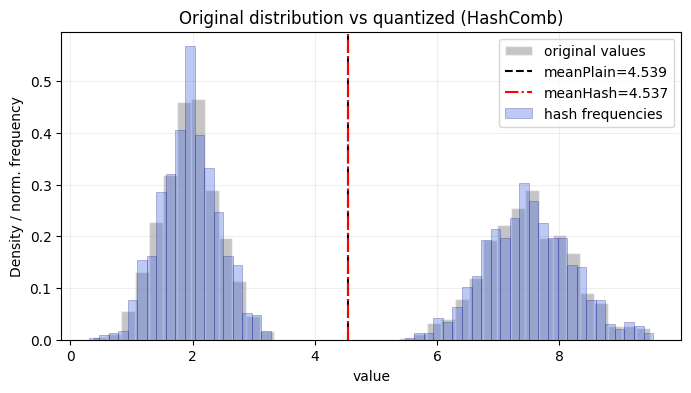

In [9]:
rng = np.random.default_rng(7)
cluster_a = rng.normal(loc=2.0, scale=0.5, size=800)
cluster_b = rng.normal(loc=7.5, scale=0.7, size=700)
values = np.clip(np.concatenate([cluster_a, cluster_b]), 0.0, 10.0)

channels = 6
enc = Encoder(channels, 10.0, 0.0, configPath="artifacts/cluster.pkl")
dec = Decoder(configPath="artifacts/cluster.pkl")

tokens = [enc.encode(v) for v in values]
counts = Counter(tokens)

mean_plain = float(values.mean())
mean_hash = float(np.mean([dec.decode(t) for t in tokens]))
plot_hash_distribution([values], counts, dec, mean_plain, mean_hash)

### 3.3 *Cluster stats*

In [10]:
df = pd.DataFrame({"value": values, "token": tokens})
stats = (
    df.groupby("token")
    .agg(count=("value", "size"), mean=("value", "mean"), min=("value", "min"), max=("value", "max"))
    .reset_index()
)
stats["center"] = stats["token"].map(lambda t: dec.decode(t))
stats = stats.sort_values("center").reset_index(drop=True)
stats.head(10)

,token,count,mean,min,max,center
0,170984238,1,0.374281,0.374281,0.374281,0.390625
1,116151123,2,0.605003,0.590215,0.619791,0.546875
2,111596602,3,0.722860,0.693220,0.741620,0.703125
3,49771259,4,0.888310,0.845240,0.935716,0.859375
4,234663300,18,1.018060,0.945010,1.091622,1.015625
5,88569599,36,1.187789,1.096820,1.246860,1.171875
6,168828295,38,1.340841,1.251115,1.400356,1.328125
7,256108865,67,1.489973,1.406403,1.556679,1.484375
8,171512730,75,1.644528,1.564914,1.718214,1.640625
9,130299607,95,1.801255,1.719884,1.874902,1.796875


### 3.4 *K-means (plain vs HashComb)*
Requires scikit‑learn and scipy for the demo plots.

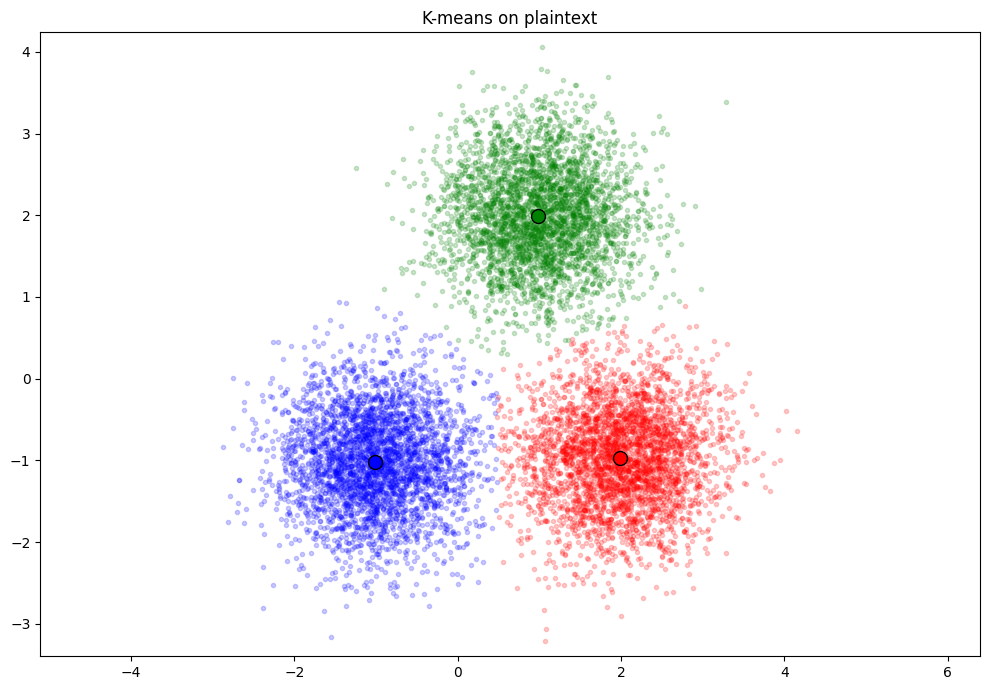

center distances (plain <-> ciphertext): [0.19433224 0.1274142  0.2715211 ]
mean center distance: 0.19775584391754708


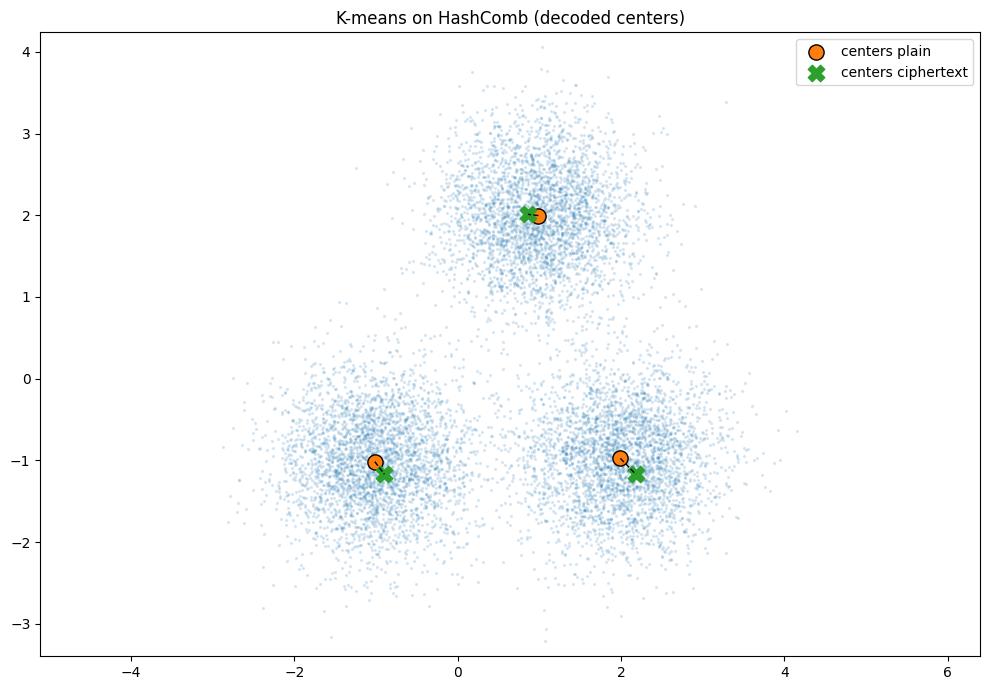

In [11]:
from itertools import cycle

try:
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from scipy.spatial.distance import cdist
except ImportError as e:
    raise ImportError("Install scikit-learn and scipy to run this section.") from e

k = 3
centers = [[1, 2], [-1, -1], [2, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6, random_state=0)


def normalizePerAxis(X):
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = np.where((maxs - mins) == 0, 1.0, (maxs - mins))
    return (X - mins) / rng, mins, rng


def denormalizePerAxis(Xn, mins, rng):
    return Xn * rng + mins


def orderedHashes1D(encoder, vmin=0.0, vmax=1.0, samples=20000):
    xs = np.linspace(vmin, vmax, samples)
    hs = encoder.encodeArray(xs)
    order = []
    last = None
    for h in hs:
        h = str(h)
        if h != last:
            order.append(h)
            last = h
    orderMap = {h: i for i, h in enumerate(order)}
    return order, orderMap


# Plain K-means reference
kmeansPlain = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(X)
labelsPlain = kmeansPlain.labels_
centersPlain = kmeansPlain.cluster_centers_

plt.figure(figsize=(10, 7))
colors = cycle("bgrcmyk")
for k_, col in zip(range(k), colors):
    mask = labelsPlain == k_
    c = centersPlain[k_]
    plt.plot(X[mask, 0], X[mask, 1], col + ".", alpha=0.2)
    plt.plot(c[0], c[1], "o", markerfacecolor=col, markeredgecolor="k", markersize=10)
plt.axis("equal")
plt.title("K-means on plaintext")
plt.tight_layout()
plt.show()


# HashComb K-means (ciphertext space)
Xn, mins, rng = normalizePerAxis(X)

channels = 4
minVal = 0.0
maxVal = 1.0
configX = "artifacts/configurationDemo_KM_X.pkl"
configY = "artifacts/configurationDemo_KM_Y.pkl"
encoderX = Encoder(channels, maxVal, minVal, configPath=configX)
decoderX = Decoder(configPath=configX)
encoderY = Encoder(channels, maxVal, minVal, configPath=configY)
decoderY = Decoder(configPath=configY)

encX = encoderX.encodeArray(Xn[:, 0])
encY = encoderY.encodeArray(Xn[:, 1])

orderX, orderMapX = orderedHashes1D(encoderX, minVal, maxVal)
orderY, orderMapY = orderedHashes1D(encoderY, minVal, maxVal)

ix = np.array([orderMapX[str(h)] for h in encX], dtype=np.int32)
iy = np.array([orderMapY[str(h)] for h in encY], dtype=np.int32)

pairs = np.column_stack([ix, iy])
keyTuples, inverse, counts = np.unique(pairs, axis=0, return_inverse=True, return_counts=True)

kmeansCipher = KMeans(n_clusters=k, n_init="auto", random_state=0)
kmeansCipher.fit(keyTuples, sample_weight=counts)
centersIdx = kmeansCipher.cluster_centers_

centersIdxRound = np.rint(centersIdx).astype(int)
centersIdxRound[:, 0] = np.clip(centersIdxRound[:, 0], 0, len(orderX) - 1)
centersIdxRound[:, 1] = np.clip(centersIdxRound[:, 1], 0, len(orderY) - 1)

centerHashesX = [orderX[i] for i in centersIdxRound[:, 0]]
centerHashesY = [orderY[i] for i in centersIdxRound[:, 1]]

cx = decoderX.decodeArray(np.array(centerHashesX, dtype=object))
cy = decoderY.decodeArray(np.array(centerHashesY, dtype=object))
centersCipherDecoded01 = np.column_stack([cx, cy]).astype(np.float32)
centersCipherDecoded = denormalizePerAxis(centersCipherDecoded01, mins, rng)


def matchCenters(A, B):
    D = cdist(A, B)
    order = D.argmin(axis=1)
    return B[order], D[np.arange(len(A)), order]


centersCipherMatched, dists = matchCenters(centersPlain, centersCipherDecoded)
print("center distances (plain <-> ciphertext):", dists)
print("mean center distance:", float(dists.mean()))

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], s=2, alpha=0.12)
plt.scatter(centersPlain[:, 0], centersPlain[:, 1], marker="o", s=120, edgecolor="k", label="centers plain")
plt.scatter(centersCipherMatched[:, 0], centersCipherMatched[:, 1], marker="X", s=140, label="centers ciphertext")
for a, b in zip(centersPlain, centersCipherMatched):
    plt.plot([a[0], b[0]], [a[1], b[1]], "k--", linewidth=1)

plt.axis("equal")
plt.legend()
plt.title("K-means on HashComb (decoded centers)")
plt.tight_layout()
plt.show()

### 3.5 *HashComb K‑voting grid*
Grid overlay of HashComb leaf bins with vote density.

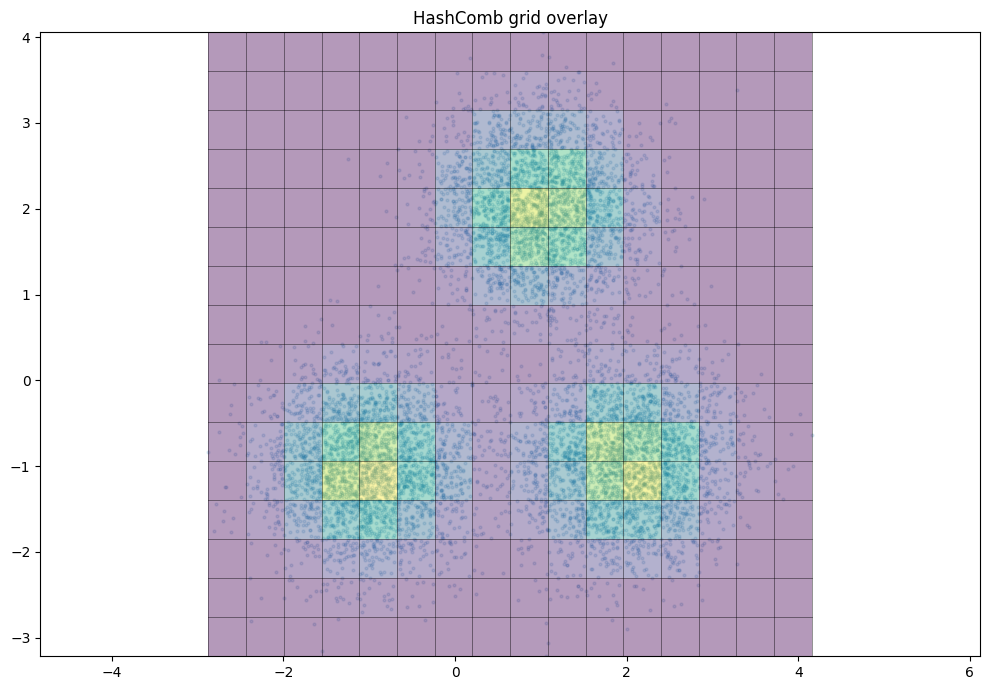

In [12]:
counts_grid = np.zeros((len(orderX), len(orderY)), dtype=np.int32)
np.add.at(counts_grid, (ix, iy), 1)

edgesX01 = np.linspace(0.0, 1.0, len(orderX) + 1)
edgesY01 = np.linspace(0.0, 1.0, len(orderY) + 1)

# denormalized edges (original scale)
ex = edgesX01 * rng[0] + mins[0]
ey = edgesY01 * rng[1] + mins[1]

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=0.15)

# draw bucket lines
for xg in ex:
    plt.plot([xg, xg], [ey[0], ey[-1]], "k", linewidth=0.6, alpha=0.5)
for yg in ey:
    plt.plot([ex[0], ex[-1]], [yg, yg], "k", linewidth=0.6, alpha=0.5)

Z = (counts_grid.T / max(counts_grid.max(), 1)).astype(float)
EX, EY = np.meshgrid(ex, ey, indexing="xy")
plt.pcolormesh(EX, EY, Z, alpha=0.4)

plt.title("HashComb grid overlay")
plt.axis("equal")
plt.tight_layout()
plt.show()

### 3.6 *K-means with full paths*
Each value is represented by its full root→leaf path (decoded centers), then clustered.

center distances (plain <-> full-path): [0.02031183 0.01257216 0.01832366]
mean center distance: 0.0170692152226912


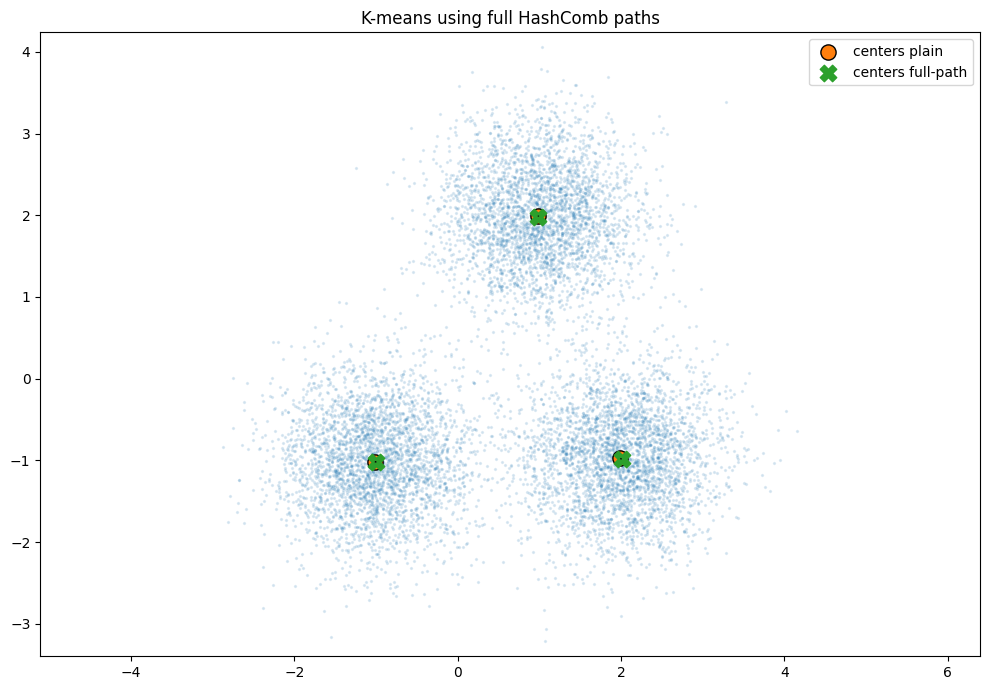

In [13]:
# Build encoders that include internal nodes so full paths can be decoded
configX_full = "artifacts/configurationDemo_KM_X_full.pkl"
configY_full = "artifacts/configurationDemo_KM_Y_full.pkl"
encX_full = Encoder(channels, maxVal, minVal, configPath=configX_full, includeInternal=True)
decX_full = Decoder(configPath=configX_full)
encY_full = Encoder(channels, maxVal, minVal, configPath=configY_full, includeInternal=True)
decY_full = Decoder(configPath=configY_full)

# Encode full paths (root→leaf) and decode each node to centers
paths_x = [encX_full.encodePath(v) for v in Xn[:, 0]]
paths_y = [encY_full.encodePath(v) for v in Xn[:, 1]]

feat_x = np.array([[decX_full.decode(t) for t in p] for p in paths_x], dtype=np.float32)
feat_y = np.array([[decY_full.decode(t) for t in p] for p in paths_y], dtype=np.float32)

# Feature vector is concatenation of x-path and y-path centers
features = np.hstack([feat_x, feat_y])

kmeansPath = KMeans(n_clusters=k, n_init="auto", random_state=0)
labelsPath = kmeansPath.fit_predict(features)
centersPath = kmeansPath.cluster_centers_

# Decode centers back to 2D by taking the last level of each path
centersPath_x01 = centersPath[:, channels - 1]
centersPath_y01 = centersPath[:, 2 * channels - 1]
centersPathDecoded01 = np.column_stack([centersPath_x01, centersPath_y01])
centersPathDecoded = denormalizePerAxis(centersPathDecoded01, mins, rng)

centersPathMatched, dists_path = matchCenters(centersPlain, centersPathDecoded)
print("center distances (plain <-> full-path):", dists_path)
print("mean center distance:", float(dists_path.mean()))

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], s=2, alpha=0.12)
plt.scatter(centersPlain[:, 0], centersPlain[:, 1], marker="o", s=120, edgecolor="k", label="centers plain")
plt.scatter(centersPathMatched[:, 0], centersPathMatched[:, 1], marker="X", s=140, label="centers full-path")
for a, b in zip(centersPlain, centersPathMatched):
    plt.plot([a[0], b[0]], [a[1], b[1]], "k--", linewidth=1)

plt.axis("equal")
plt.legend()
plt.title("K-means using full HashComb paths")
plt.tight_layout()
plt.show()

### 3.7 *Voting grids by layer*
Each subplot shows the voting grid for a different tree level (root → leaf).

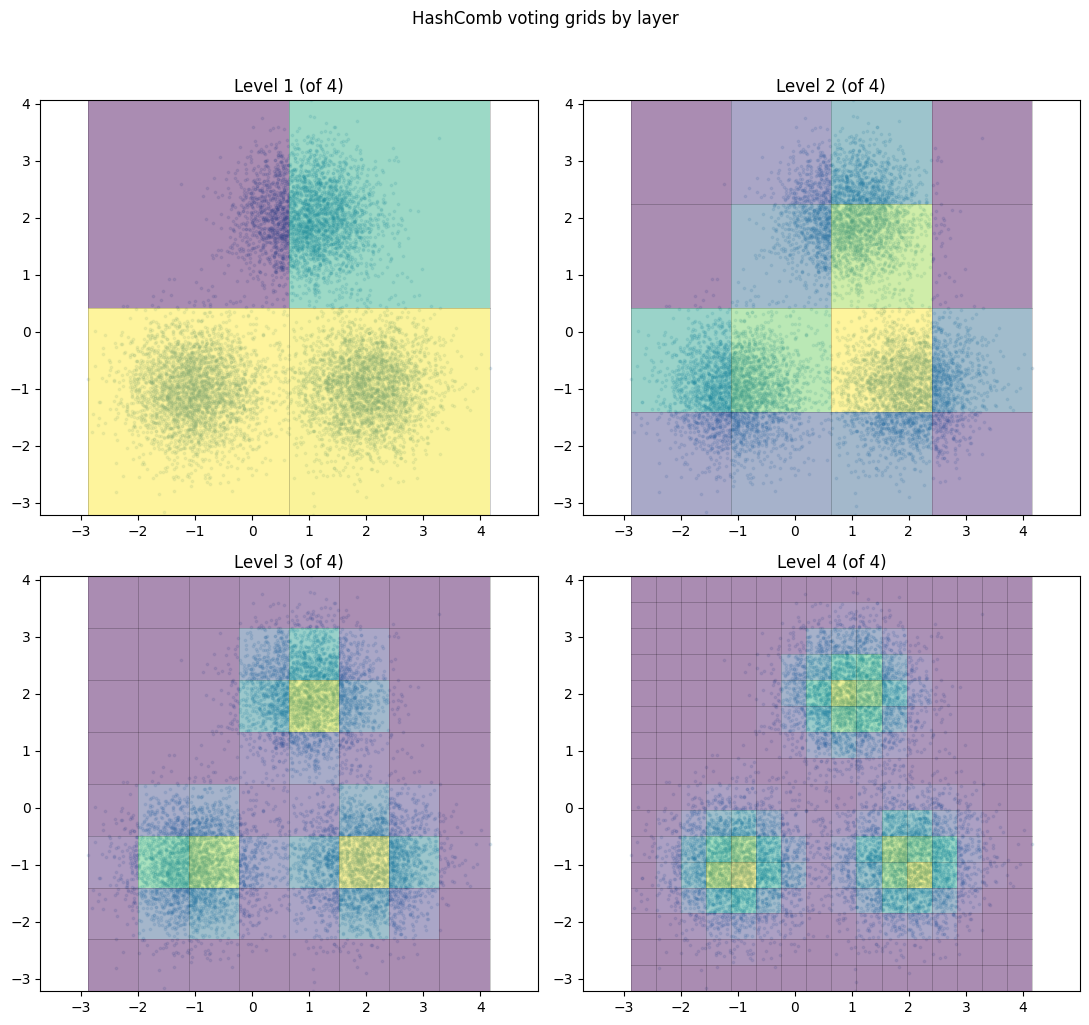

In [14]:
def orderedHashes1D_level(encoder, level, vmin=0.0, vmax=1.0, samples=20000):
    xs = np.linspace(vmin, vmax, samples)
    order = []
    last = None
    for x in xs:
        path = encoder.encodePath(float(x))
        tok = str(path[level])
        if tok != last:
            order.append(tok)
            last = tok
    orderMap = {h: i for i, h in enumerate(order)}
    return order, orderMap


def grid_from_level(paths_x, paths_y, orderMapX, orderMapY, level):
    ix_l = np.array([orderMapX[str(p[level])] for p in paths_x], dtype=np.int32)
    iy_l = np.array([orderMapY[str(p[level])] for p in paths_y], dtype=np.int32)
    grid = np.zeros((len(orderMapX), len(orderMapY)), dtype=np.int32)
    np.add.at(grid, (ix_l, iy_l), 1)
    return grid


n_levels = channels
cols = 2
rows = int(np.ceil(n_levels / cols))
fig, axes = plt.subplots(rows, cols, figsize=(11, 5 * rows))
axes = np.atleast_1d(axes).reshape(rows, cols)

for level in range(n_levels):
    orderX_l, orderMapX_l = orderedHashes1D_level(encX_full, level, minVal, maxVal)
    orderY_l, orderMapY_l = orderedHashes1D_level(encY_full, level, minVal, maxVal)

    grid = grid_from_level(paths_x, paths_y, orderMapX_l, orderMapY_l, level)

    edgesX01 = np.linspace(0.0, 1.0, len(orderX_l) + 1)
    edgesY01 = np.linspace(0.0, 1.0, len(orderY_l) + 1)
    ex_l = edgesX01 * rng[0] + mins[0]
    ey_l = edgesY01 * rng[1] + mins[1]

    ax = axes[level // cols, level % cols]
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.12)

    Z = (grid.T / max(grid.max(), 1)).astype(float)
    EX_l, EY_l = np.meshgrid(ex_l, ey_l, indexing="xy")
    ax.pcolormesh(EX_l, EY_l, Z, alpha=0.45)

    for xg in ex_l:
        ax.plot([xg, xg], [ey_l[0], ey_l[-1]], "k", linewidth=0.4, alpha=0.35)
    for yg in ey_l:
        ax.plot([ex_l[0], ex_l[-1]], [yg, yg], "k", linewidth=0.4, alpha=0.35)

    ax.set_title(f"Level {level + 1} (of {n_levels})")
    ax.axis("equal")

# Hide unused axes if any
for extra in range(n_levels, rows * cols):
    fig.delaxes(axes[extra // cols, extra % cols])

fig.suptitle("HashComb voting grids by layer", y=1.02)
fig.tight_layout()
plt.show()